\newpage

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from ucimlrepo import fetch_ucirepo
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

1. The classification problem involves determining the presence of heart disease in a person. In the dataset, this outcome is recorded in the column `num`, an integer ranging from 0 (no presence) to 4.

In [65]:
heart_disease = pd.read_csv("https://raw.githubusercontent.com/PratheepaJ/datasets/refs/heads/master/ass6-dataset.csv")
heart_disease.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


2. It is necessary to transform both the continuous variables in the dataset. They need to be scaled. Categorical variables need to be transformed to one-hot encoding. Binary categorical variables were transformed into a categorical variable type.

In [55]:
heart_disease['sex'] = pd.Categorical(heart_disease['sex'])
heart_disease['fbs'] = pd.Categorical(heart_disease['fbs'])
heart_disease['exang'] = pd.Categorical(heart_disease['exang'])

In [66]:
scaler = StandardScaler()
# scale the listed columns since they are numerical
data_transformed = heart_disease.copy()
num_cols = ['age','trestbps','chol','thalach','oldpeak','ca']
data_transformed[num_cols] = scaler.fit_transform(heart_disease[num_cols])

In [92]:
# one-hot encoding for other variables
categorical_col = ['cp', 'restecg', 'slope', 'thal']
data_transformed = pd.get_dummies(data_transformed, columns=categorical_col, dummy_na=True, drop_first=True)



In [93]:
data_transformed.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,...,cp_nan,restecg_1.0,restecg_2.0,restecg_nan,slope_2.0,slope_3.0,slope_nan,thal_6.0,thal_7.0,thal_nan
0,0.948726,1,0.757525,-0.264900,1,0.017197,0,1.087338,-0.718306,0,...,False,False,True,False,False,True,False,True,False,False
1,1.392002,1,1.611220,0.760415,0,-1.821905,1,0.397182,2.487269,1,...,False,False,True,False,True,False,False,False,False,False
2,1.392002,1,-0.665300,-0.342283,0,-0.902354,1,1.346147,1.418744,1,...,False,False,True,False,True,False,False,False,True,False
3,-1.932564,1,-0.096170,0.063974,0,1.637359,0,2.122573,-0.718306,0,...,False,False,False,False,False,True,False,False,False,False
4,-1.489288,0,-0.096170,-0.825922,0,0.980537,0,0.310912,-0.718306,0,...,False,False,True,False,False,False,False,False,False,False


3. The dataset has 303 observations with 13 predictor variables and one response variable called `num`. 

The variable types are:  
age: integer  
sex: categorical, stored as integer   
cp: integer  
trestbps: integer  
chol: integer  
fbs: categorical, stored as integer   
restecg: integer  
thalach: integer  
exang: categorical, stored as integer  
oldpeak: continunous  
slope: integer  
ca: continuous  
thal: continuous  
num: integer (categorical response variable)

In [61]:
heart_disease.shape

(303, 14)

In [62]:
heart_disease.dtypes

age            int64
sex         category
cp             int64
trestbps       int64
chol           int64
fbs         category
restecg        int64
thalach        int64
exang       category
oldpeak      float64
slope          int64
ca           float64
thal         float64
num            int64
dtype: object

In [63]:
heart_disease.describe()

,age,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,3.158416,131.689769,246.693069,0.990099,149.607261,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.960126,17.599748,51.776918,0.994971,22.875003,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,1.000000,94.000000,126.000000,0.000000,71.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,3.000000,120.000000,211.000000,0.000000,133.500000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,3.000000,130.000000,241.000000,1.000000,153.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,4.000000,140.000000,275.000000,2.000000,166.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,4.000000,200.000000,564.000000,2.000000,202.000000,6.200000,3.000000,3.000000,7.000000,4.000000


<Axes: xlabel='num', ylabel='count'>

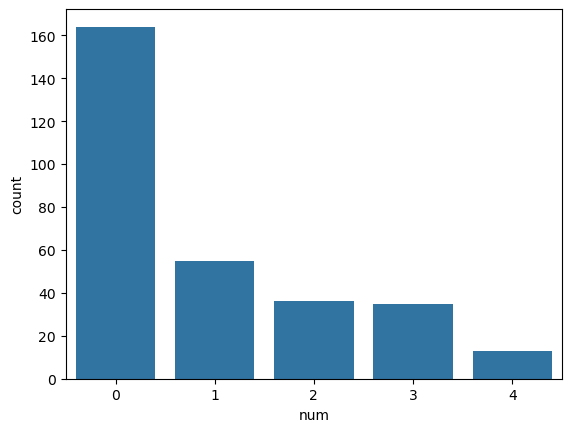

In [64]:
sns.countplot(x=heart_disease['num'])

<Axes: xlabel='age', ylabel='count'>

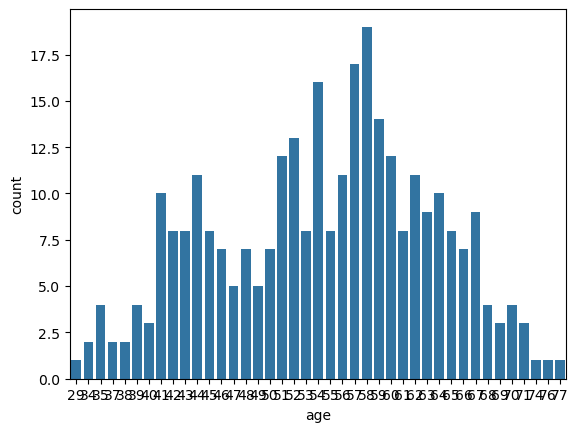

In [32]:
sns.countplot(x=heart_disease['age'])

4. Dataset transformation: turning `num` into a binary outcome

In [95]:
heart_disease['num'] = heart_disease['num'].apply(lambda x: 0 if x == 0 else 1)
# also do this for the transformed dataset
data_transformed['num'] = data_transformed['num'].apply(lambda x: 0 if x == 0 else 1)

5. Relationships between variables: use correlation plot. From the plot, most variables are not highly correlated. The most highly correlated variables are `oldpeak` and `slope` with a correlation of 0.58, signifying moderate correlation. With feature selection, this may inform our dimension reduction choices; if two variables are highly correlated we may remove one. However, a technique like principal component analysis is needed to confirm these choices. The variables that are the most correlated with the response variable are `cp`, `exang`, `oldpeak`, `ca`, and `thal`, all moderately correlated. It is also negatively correlated with `thalach`. For feature extraction, we may focus on using these variables as they seem to be the most useful in predicting an outcome of whether a person has heart disease or not. In general, none of the variables are very highly correlated, i.e. above 0.7. There is no clear indication that we should drop any one variable.

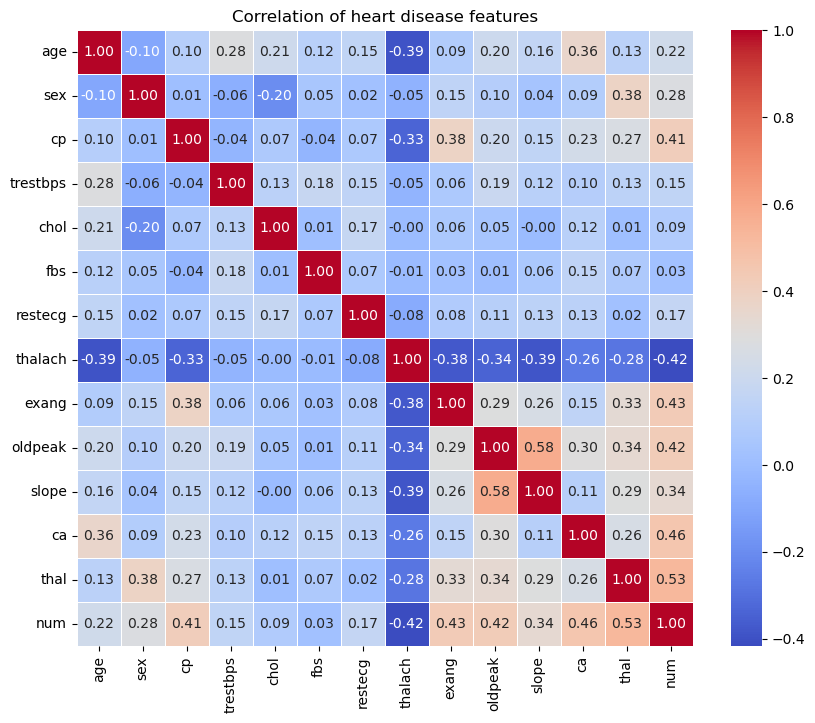

In [96]:
numerical_vars = heart_disease.select_dtypes(include=[np.number])
scaler = StandardScaler()
numerical_vars_scaled = pd.DataFrame(scaler.fit_transform(numerical_vars), columns=numerical_vars.columns)
corr_matrix = numerical_vars_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation of heart disease features')
plt.show()

6. There are 297 observations after dropping the missing values.

In [97]:
data_transformed.isna().sum() # some values are NA meaning missing

age            0
sex            0
trestbps       0
chol           0
fbs            0
thalach        0
exang          0
oldpeak        0
ca             0
num            0
cp_2.0         0
cp_3.0         0
cp_4.0         0
cp_nan         0
restecg_1.0    0
restecg_2.0    0
restecg_nan    0
slope_2.0      0
slope_3.0      0
slope_nan      0
thal_6.0       0
thal_7.0       0
thal_nan       0
dtype: int64

In [98]:
# Also drop from categorical variables that were one-hot encoded as NAN
data_transformed = data_transformed[data_transformed['cp_nan']==False]
data_transformed = data_transformed[data_transformed['slope_nan']==False]
data_transformed = data_transformed[data_transformed['thal_nan']==False]

In [99]:
# drop any values that are NA
data_transformed = data_transformed.dropna(axis=0)

In [100]:
data_transformed.shape

(297, 23)

7. Sub-group analysis; using only the numerical columns in the dataset (defined in the answer to question 2), k-means clustering and principal component analysis was done. K-means worked best with k=2 clusters. With PCA, it was best to keep 2 principal components due to the elbow in the scree plot at two principal components. 

In [75]:
clust_df = data_transformed.select_dtypes(include=[np.number])
clust_df = clust_df.drop(columns=['num'])
print(clust_df.head())

        age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  0.948726    1   1  0.757525 -0.264900    1        2  0.017197      0   
1  1.392002    1   4  1.611220  0.760415    0        2 -1.821905      1   
2  1.392002    1   4 -0.665300 -0.342283    0        2 -0.902354      1   
3 -1.932564    1   3 -0.096170  0.063974    0        0  1.637359      0   
4 -1.489288    0   2 -0.096170 -0.825922    0        2  0.980537      0   

    oldpeak  slope        ca  thal  
0  1.087338      3 -0.718306   6.0  
1  0.397182      2  2.487269   3.0  
2  1.346147      2  1.418744   7.0  
3  2.122573      3 -0.718306   3.0  
4  0.310912      1 -0.718306   3.0  


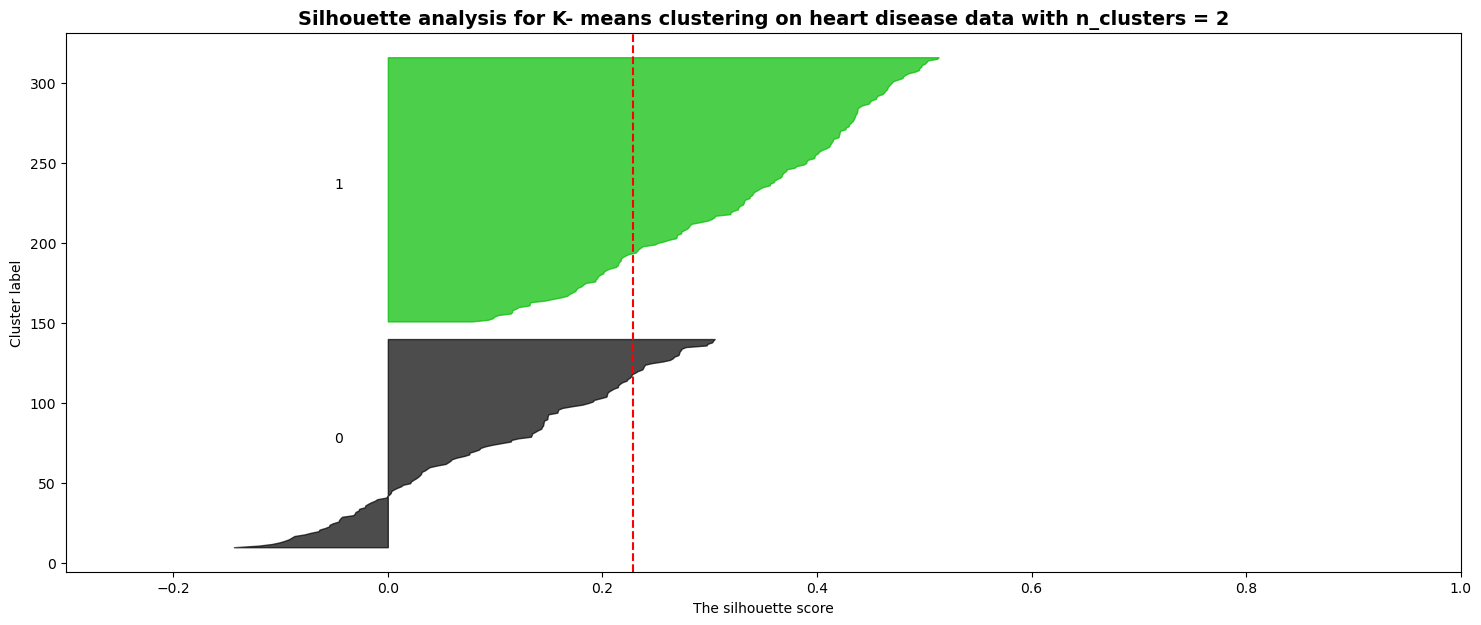

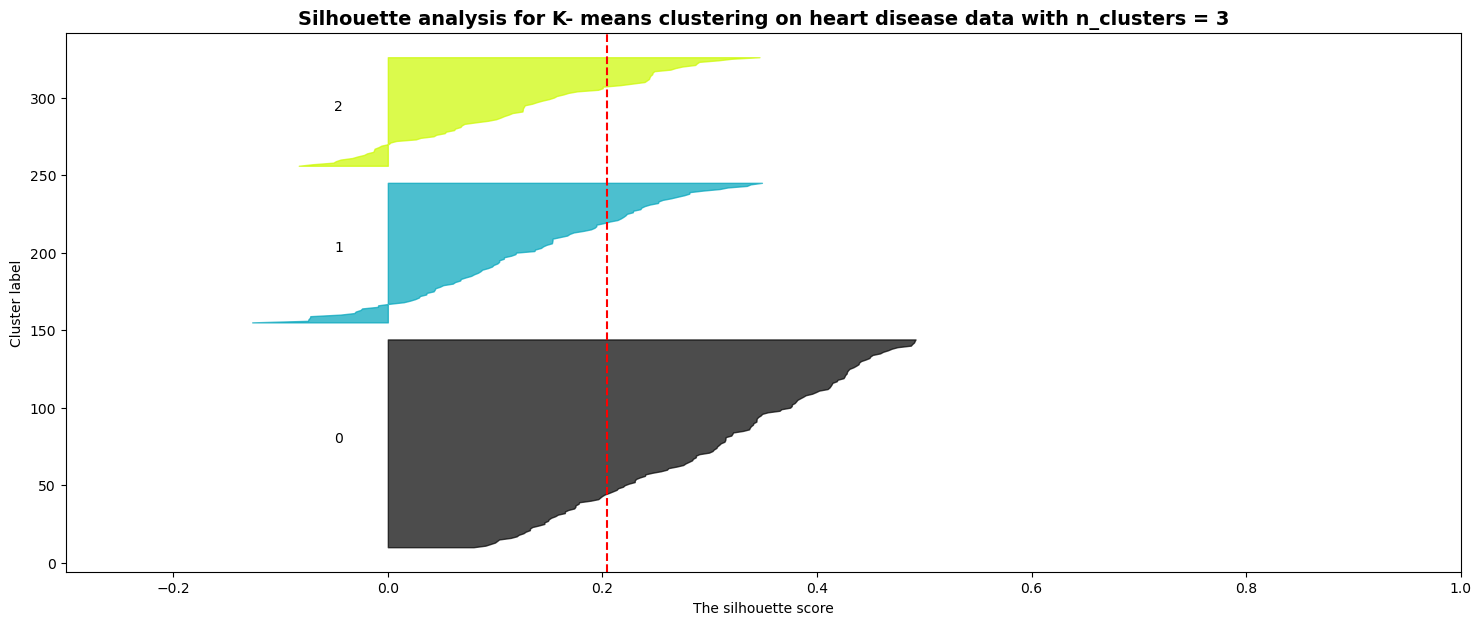

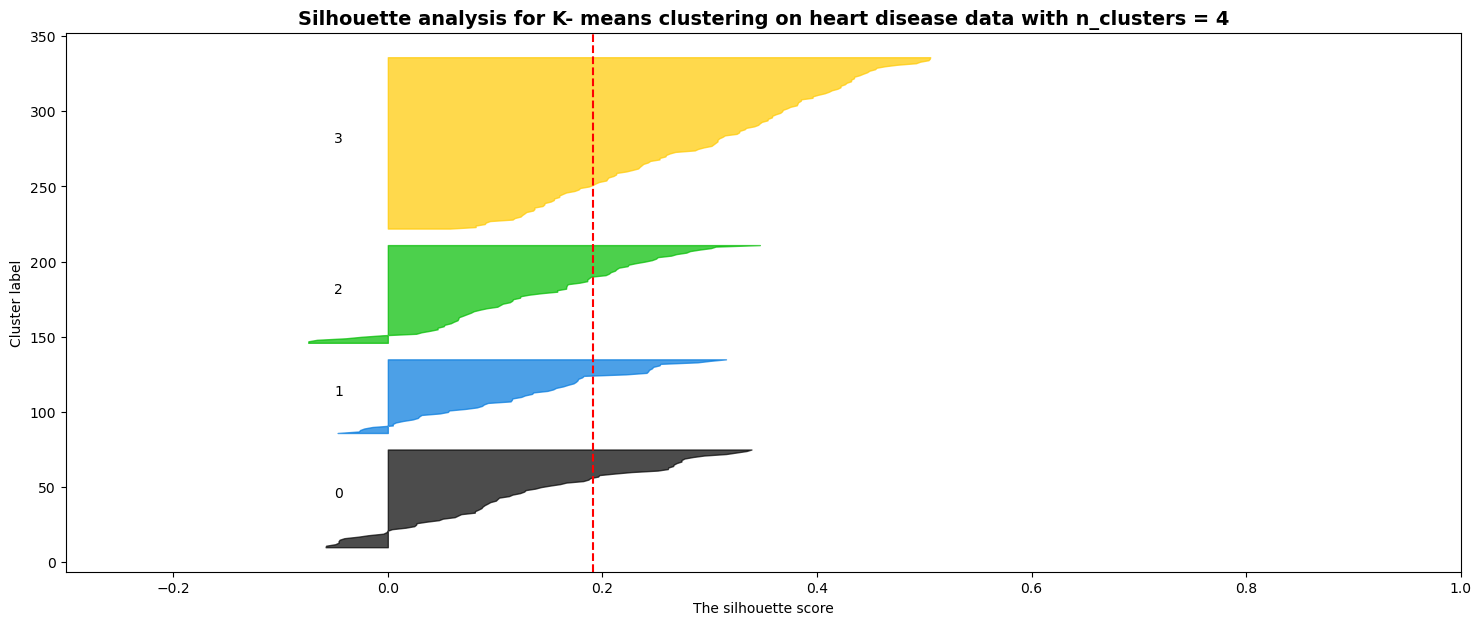

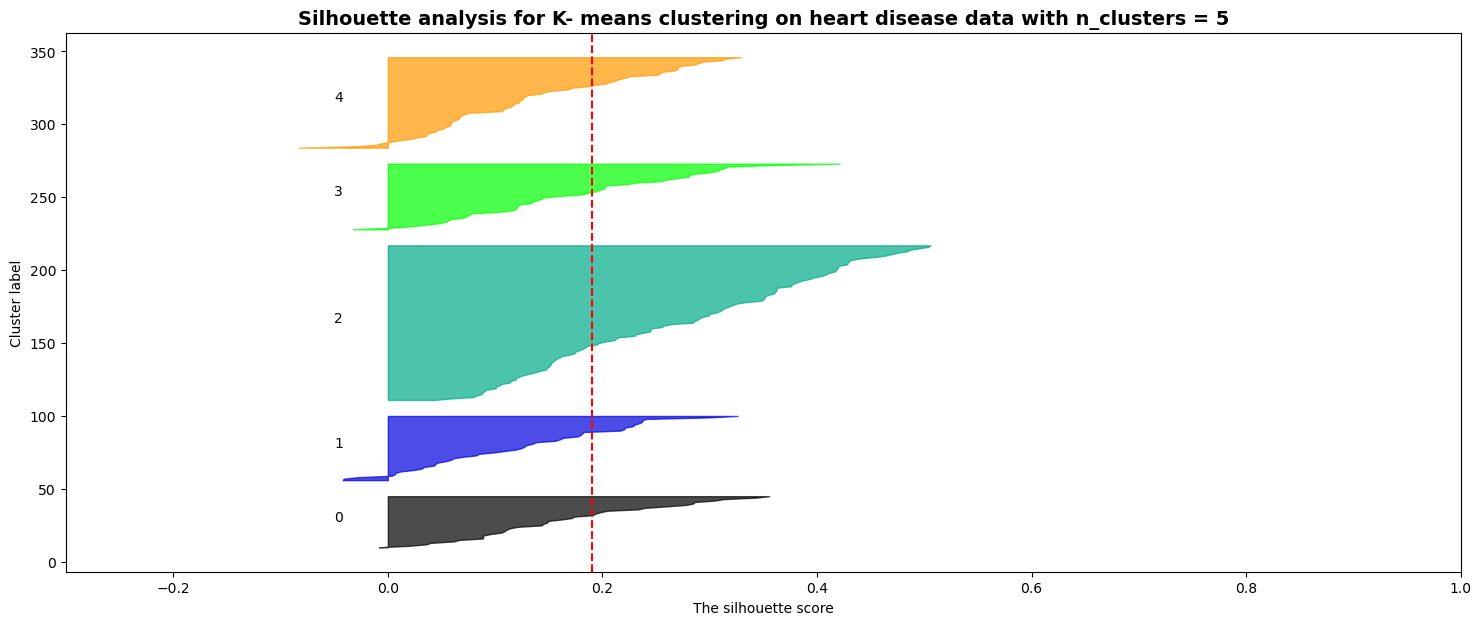

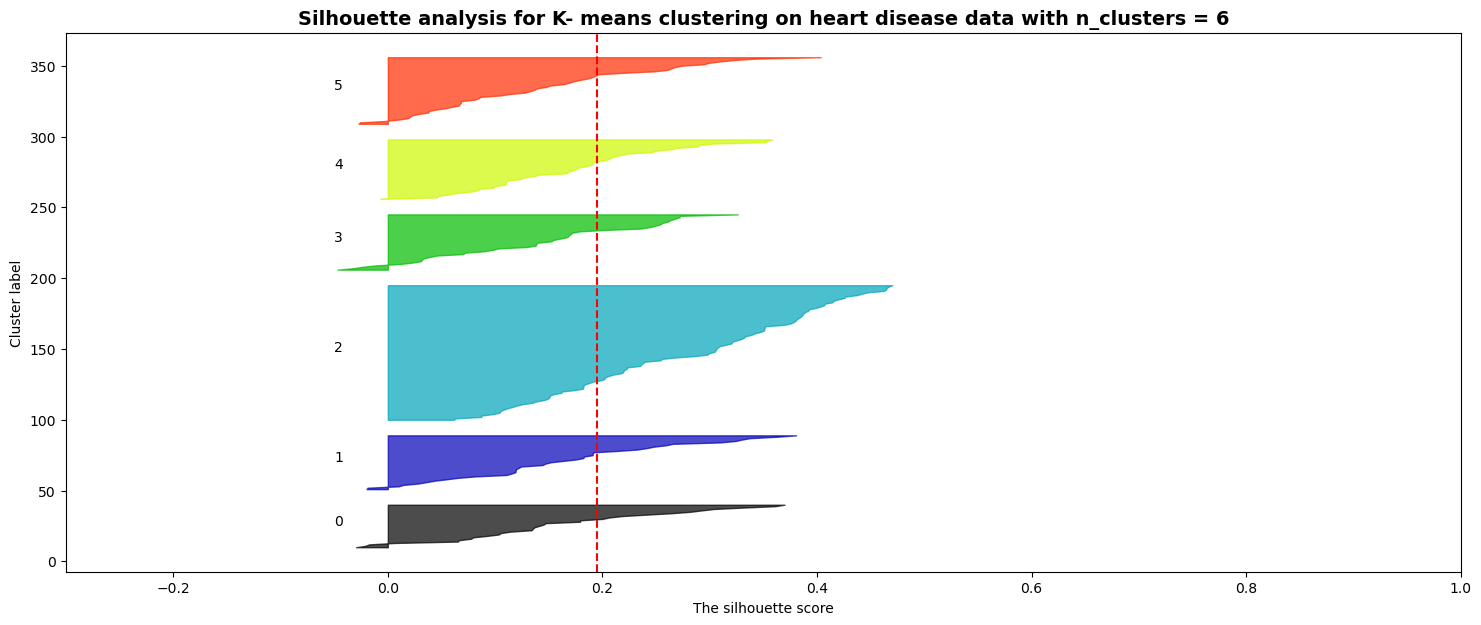

In [78]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, n_init = 20, random_state=0)
    cluster_labels_km = km.fit_predict(data_transformed[num_cols])
    # average silhouette score
    silhouette_avg_km = silhouette_score(data_transformed[num_cols], cluster_labels_km)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_transformed[num_cols], cluster_labels_km)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.3, 1])# change this based on the silhouette range

    y_lower = 10
    
    for i in range(n_clusters):
        # aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            y=np.arange(y_lower, y_upper),
            x1=0,
            x2=ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next cluster silhouette scores
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette score")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for K- means clustering on heart disease data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [81]:
km2 = KMeans(n_clusters=2, n_init=20, random_state=0)
cluster_labels_km = km.fit_predict(data_transformed[num_cols])

silhouette_avg_km2 = silhouette_score(data_transformed[num_cols], data_transformed['num'])

# silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data_transformed[num_cols], data_transformed['num'])

km2.fit(data_transformed)
preds = km2.labels_

print(len(np.where(preds==0)[0]))
print(len(np.where(preds==1)[0]))

164
133


In [85]:
# Now do principal component analysis
pca_heart = PCA()
pca_heart.fit(data_transformed[num_cols])
pca_heart.components_.shape[0]

6

In [86]:
pca_loadings = pd.DataFrame(
    pca_heart.fit(data_transformed[num_cols]).components_.T, 
    index=data_transformed[num_cols].columns, 
    columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'])
pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6
age,0.517152,0.153299,-0.101056,-0.543527,-0.002139,0.635149
trestbps,0.307883,0.495496,0.731941,-0.088006,0.089901,-0.328829
chol,0.200119,0.678037,-0.517097,0.338152,-0.322402,-0.120578
thalach,-0.455537,0.420671,0.107463,0.266564,0.516071,0.516322
oldpeak,0.429655,-0.282572,0.280061,0.702804,-0.175675,0.363758
ca,0.453429,-0.120156,-0.310933,0.132274,0.768622,-0.273880


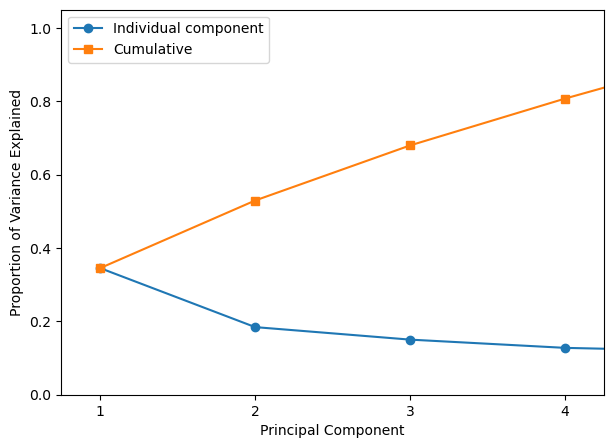

In [87]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4,5,6], pca_heart.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4,5,6], np.cumsum(pca_heart.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

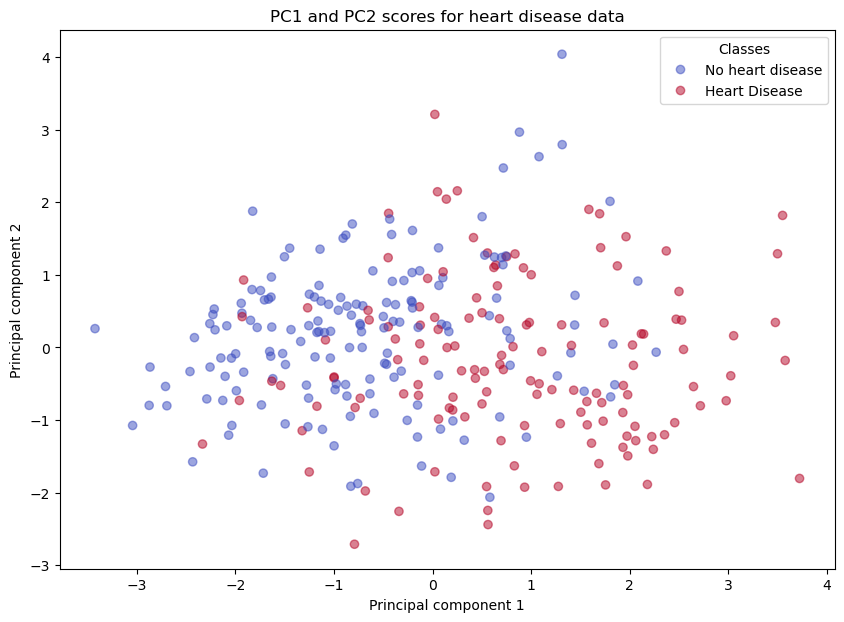

In [90]:
pc_scores = pd.DataFrame(
    pca_heart.fit_transform(data_transformed[num_cols]), 
    index=data_transformed[num_cols].index,
    columns=[f'PC{i+1}' for i in range(pca_heart.n_components_)]
    )

pc_scores['num'] = pd.Categorical(data_transformed['num'])
pc_scores.dtypes

status_codes = pc_scores['num'].cat.codes
status_labels = pc_scores['num'].cat.categories

plt.figure(figsize=(10, 7))

scatter_plt = plt.scatter(
    pc_scores['PC1'], 
    pc_scores['PC2'], 
    c=status_codes, 
    cmap='coolwarm',
    alpha=0.5
)

handles, labels = scatter_plt.legend_elements()
legend = plt.legend(handles = handles, labels = ["No heart disease", "Heart Disease"], title="Classes")

# axes and title labels
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PC1 and PC2 scores for heart disease data')

plt.show()

8. 

In [91]:
X = data_transformed.drop('num',axis=1)
Y = data_transformed['num']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1, stratify=Y)

9. The chosen classifiers are the random forest classifier and logistic regression. Both methods are suitable for binary classification which is the objective for this dataset. The random forest is able to handle both categorical and numeric data while avoiding overfitting. It is interpretable and can also handle nonlinear relationships between variables and feature importance. Logistic regression outputs probabilities for binary classes, which is the goal for the dataset. It is also interpretable and fast.

10. A metric that may be used for both methods is accuracy, i.e. how many of the testing data are classified correctly as a proportion of the total number of test data. Another method is ROC analysis. It investigates the sensitivity (true positives) and specificity (true negatives) rates to represent the accuracy. In the context of heart disease data, it is important to not miss instances of disease, thus, sensitivity is very important in particular. More specifically, ROC investigates the trade-off between sensitivity and specificity. We will also study the AUC (area under the ROC curve), a measure of how good the model is at separating the two classes. An AUC of 1 is ideal and an AUC of 0 means the model performed no better than random guessing.

11. Classifiers are trained in the cells below. There are no applicable tuning parameters for logistic regression. For the random forest, the number of trees and maximum number of features were parameters that were tuned. The chosen training parameters for the random forest were 8 features and 200 trees.

In [155]:
# first do logistic regression
m_log = LogisticRegression(max_iter=120)
m_log.fit(X_train, y_train)
pred_prob = m_log.predict_proba(X_test)
df_roc = pd.DataFrame(
    data = {'prob1': pred_prob[:,1], 'y_test': y_test}
    )
df_roc.head()

,prob1,y_test
95,0.866535,1
299,0.887221,1
221,0.028118,0
210,0.025297,0
43,0.083131,0


In [157]:
df_roc['y_test_pred'] = df_roc.prob1.map(lambda x: 1 if x>0.5 else 0)
df_roc.head()

,prob1,y_test,y_test_pred
95,0.866535,1,1
299,0.887221,1,1
221,0.028118,0,0
210,0.025297,0,0
43,0.083131,0,0


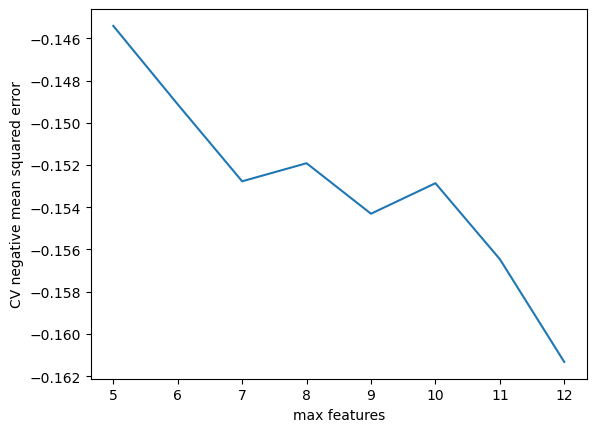

In [ ]:
scores_cv = []
m_feas = range(5,13)
for m_fea in m_feas:
    scores = cross_val_score(
        RandomForestClassifier(
    n_estimators = 200,
    max_features=m_fea, 
    random_state=1, 
    bootstrap=True, 
    oob_score=True), 
    X_train,
    y_train, 
    cv=5,
    scoring='neg_mean_squared_error')
    scores_cv.append(scores.mean())
    
plt.plot(m_feas, scores_cv)
plt.xlabel('max features')
plt.ylabel('CV negative mean squared error')
plt.show()

/Users/samanthayang/anaconda3/envs/stats3da3w25_3.11.5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samanthayang/anaconda3/envs/stats3da3w25_3.11.5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samanthayang/anaconda3/envs/stats3da3w25_3.11.5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samanthayang/anaconda3/envs/stats3da3w25_3.11.5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reli

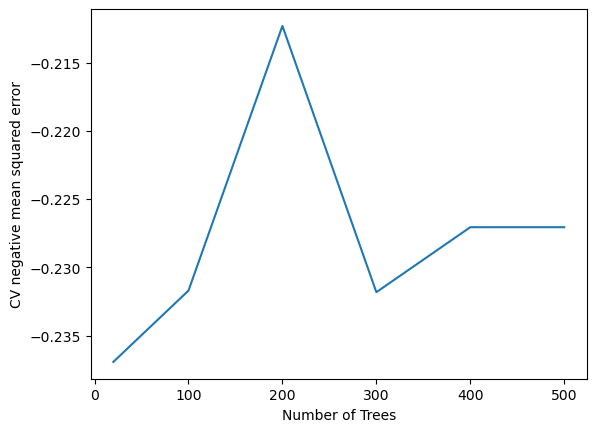

In [175]:
scores_cv = []
ntrees = [20, 100, 200, 300, 400, 500]
for n in ntrees:
    scores = cross_val_score(
        RandomForestClassifier(n_estimators=n, max_features=8, random_state=0, bootstrap=True, oob_score=True), 
        X_train, 
        y_train, 
        cv=5,
        scoring='neg_mean_squared_error'
    )
    scores_cv.append(scores.mean())

plt.plot(ntrees, scores_cv)
plt.xlabel('Number of Trees')
plt.ylabel('CV negative mean squared error')
plt.show()

In [200]:
# We can use 100 treees
rf_heart = RandomForestClassifier(
    n_estimators = 200,
    max_features=8, 
    random_state=1, 
    bootstrap=True, 
    oob_score=True)

rf_heart.fit(X_train, y_train)
rf_y_pred = rf_heart.predict(X_test)

12. PCA was used as a feature selection method. Based on the answer to question 7, we used 2 principal components. Logistic regression was applied using PCA.

In [166]:
pca = PCA(n_components = 2)
pca.fit(X_train)

# PCA on train and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [123]:
# first do logistic regression
m_log_pca = LogisticRegression(max_iter=120)
m_log_pca.fit(X_train_pca, y_train)
pred_prob_pca = m_log_pca.predict_proba(X_test_pca)
df_roc_pca = pd.DataFrame(
    data = {'prob1': pred_prob_pca[:,1], 'y_test': y_test}
    )
df_roc_pca['y_test_pred'] = df_roc_pca.prob1.map(lambda x: 1 if x>0.5 else 0)
df_roc_pca.head()

,prob1,y_test,y_test_pred
95,0.693626,1,1
299,0.937965,1,1
221,0.107694,0,0
210,0.044968,0,0
43,0.179137,0,0


13. Evaluation using classification accuracy and ROC analysis: 
Using classification accuracy, the results were as follows:
- Logistic regression: 85.56%
- Logistic regression with PCA: 80%
- Random forest: 78.89%
- Based on this metric, logistic regression performed best; it had good accuracy. The accuracy of logistic regression with PCA was slightly lower. Using PCA, we use less information from the predictors, so it is less computationally expensive but comes at an accuracy cost. Random forest performed the worst. All models were suitable to this classification problem since they all had at least moderate levels of accuracy.   

ROC analysis was also done for all classification methods. Based on the AUC scores alone, every model performed well.  
- The logistic regression had a ROC AUC score of 0.915. From the confusion matrix, this model's sensitivity was much better than its specificity. It was much better at identifying positive cases of heart disease compared to negative. 
- The logistic regression with PCA had a ROC AUC score of 0.885. From the confusion matrix, this model's sensitivity and specificity are very similar, indicating a good trade-off between the two metrics. 
- The random forest had a ROC AUC score of 0.881. From the confusion matrices above, the model's sensitivity is very poor compared to its specificity. In the context of heart disease data, this is not good because it cannot identify true positives for heart disease accurately (its sensitivity is only 71%).
- Based on the ROC analysis, we may prefer the logistic regression with the PCA. It had the best sensitivity. This makes it good for detecting important cases of heart disease. If using the metric of class accuracy alone, we would select the logsitic regression without PCA.
- In this classification problem, feature extraction (PCA) improved the model's sensitivity. Since PCA combines features with correlation and reduces noise and irrelevant variations in data, it may help the model separate the true from false positives better.

In [190]:
# accuracy metrics for each classifier
# First, logistic regression accuracy
cm = confusion_matrix(df_roc.y_test, df_roc.y_test_pred)
print('Confusion Matrix : \n', cm)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)


Confusion Matrix : 
 [[44  4]
 [ 9 33]]
Accuracy :  0.8555555555555555
Sensitivity :  0.7857142857142857
Specificity :  0.9166666666666666


In [191]:
# class accuracy for the logistic regression + PCA
cm = confusion_matrix(df_roc_pca.y_test, df_roc_pca.y_test_pred)
print('Confusion Matrix : \n', cm)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

Confusion Matrix : 
 [[38 10]
 [ 8 34]]
Accuracy :  0.8
Sensitivity :  0.8095238095238095
Specificity :  0.7916666666666666


In [183]:
# Random forest class accuracy
accuracy = accuracy_score(y_test, rf_y_pred)
print(accuracy)

cm = confusion_matrix(y_test, rf_y_pred)

print('Confusion Matrix : \n', cm)
print('Class Accuracy:', (41+30)/(41+30+7+12))

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

0.7888888888888889
Confusion Matrix : 
 [[41  7]
 [12 30]]
Class Accuracy: 0.7888888888888889
Accuracy :  0.7888888888888889
Sensitivity :  0.7142857142857143
Specificity :  0.8541666666666666


**ROC Analysis:**

In [144]:
print("Classification report for logistic regression:")
print(classification_report(df_roc.y_test, df_roc.y_test_pred))
print("Classification report for logistic regression + PCA:")
print(classification_report(df_roc_pca.y_test, df_roc_pca.y_test_pred))

Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        48
           1       0.77      0.81      0.79        42

    accuracy                           0.80        90
   macro avg       0.80      0.80      0.80        90
weighted avg       0.80      0.80      0.80        90

Classification report for logistic regression + PCA:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        48
           1       0.77      0.81      0.79        42

    accuracy                           0.80        90
   macro avg       0.80      0.80      0.80        90
weighted avg       0.80      0.80      0.80        90



In [178]:
print("Classification report for random forest:")
print(classification_report(y_test, rf_y_pred))

Classification report for random forest:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        48
           1       0.81      0.71      0.76        42

    accuracy                           0.79        90
   macro avg       0.79      0.78      0.79        90
weighted avg       0.79      0.79      0.79        90



In [170]:
fpr, tpr, thresholds = roc_curve(df_roc.y_test, df_roc.prob1)
fpr_pca, tpr_pca, thresholds_pca = roc_curve(df_roc_pca.y_test, df_roc_pca.prob1)
print('ROC AUC score for logistic regression:', roc_auc_score(df_roc.y_test, df_roc.prob1))
print('ROC AUC score for logistic regression + PCA:', roc_auc_score(df_roc_pca.y_test, df_roc_pca.prob1))

ROC AUC score for logistic regression: 0.9151785714285714
ROC AUC score for logistic regression + PCA: 0.8854166666666666


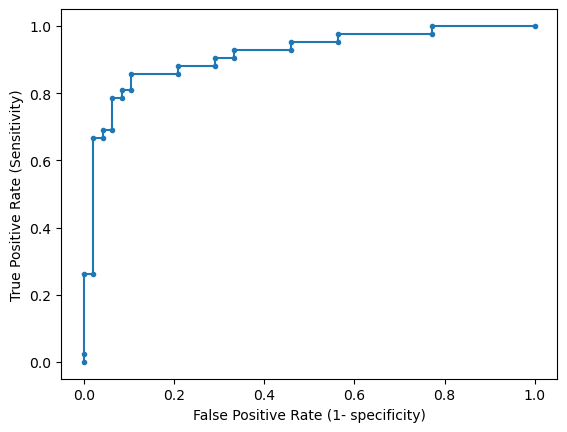

In [161]:
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

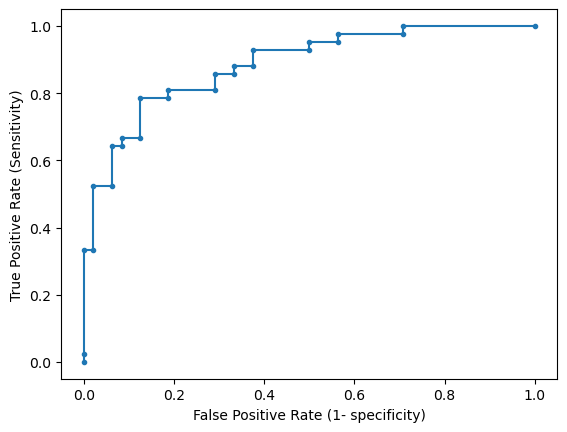

In [162]:
plt.plot(fpr_pca, tpr_pca, marker='.', label='Logistic')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [180]:
# ROC analysis of random forest
rf_y_probs = rf_heart.predict_proba(X_test)[:, 1]  # probs for class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(rf_y_pred, rf_y_probs)

# Calculate AUC (Area Under Curve)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_y_probs)

In [181]:
roc_auc_score(y_test, rf_y_probs)

0.8812003968253967

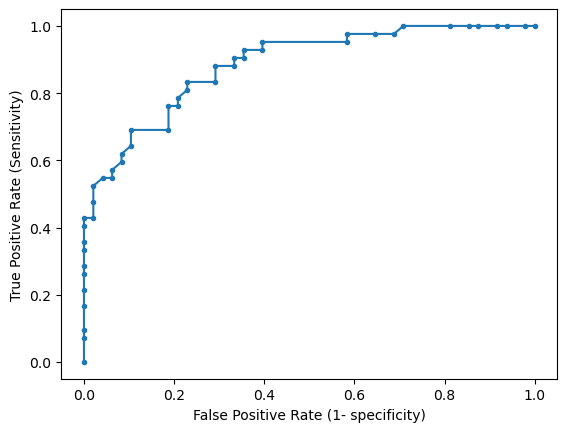

In [173]:
plt.plot(fpr_rf, tpr_rf, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

14. Analysis of random forest: based on the result from the random forest, the most important variable is `thal`, a categorical variable for whether there was a defect and if the defect was fixed or reversable. This is for the blood disorder thalassemia which affects the thallium absorption. The next most important feature was `cp`, the chest pain type. According to the random forest, the presence of thalassemia and chest pain are the most important indicators for heart disease.

In [208]:
importances = rf_heart.feature_importances_
std = np.std([rf_heart.feature_importances_ for t in rf_heart.estimators_], axis=0)
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_df

,feature,importance
12,thal,0.247837
2,cp,0.145284
9,oldpeak,0.094528
7,thalach,0.085237
4,chol,0.080074
0,age,0.078266
3,trestbps,0.077112
11,ca,0.076602
8,exang,0.045768
1,sex,0.033738


15. Sub-group improvement strategy: To improve the logistic regression combined with PCA even further, we can use cross-validation to check for the number of principal components to keep, and then use both Youden's J statistic (J) and the Kolmogorov-Smirnov (KS) statistic to change the optimal threshold to improve sensitivity. Below, we performed 5-fold cross validation on the number of principal components which verified that the best number of principal components to keep was indeed 2. Using the J statistic, the model had worse accuracy and specificity. Using the KS statistic, the model's accuracy improved slightly while the sensitivity stayed the same. Though there was no sensitivity increase, we get an overall better model with more accuracy using these statistics to change the threshold for prediction using logistic regression.

In [209]:
for k in range(1, 13):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_train)
    score = cross_val_score(LogisticRegression(), X_pca, y_train, cv=5, scoring='accuracy').mean()
    print(f'{k} PCs: {score:.4f}')

1 PCs: 0.7928
2 PCs: 0.8024
3 PCs: 0.7735
4 PCs: 0.7974
5 PCs: 0.7828
6 PCs: 0.7877
7 PCs: 0.7877
8 PCs: 0.7828
9 PCs: 0.7973
10 PCs: 0.7974
11 PCs: 0.8021
12 PCs: 0.8021


In [192]:
j_statistic = tpr_pca - fpr_pca
optimal_index = np.argmax(j_statistic)
optimal_threshold = thresholds[optimal_index]
optimal_threshold

0.44

In [195]:
ks_statistic = np.max(tpr_pca - fpr_pca)
ks_threshold = thresholds[np.argmax(tpr - fpr)]
ks_threshold

0.515

In [197]:
df_roc_pca['y_test_pred_J'] = df_roc_pca.prob1.map(lambda x: 1 if x>optimal_threshold else 0)
df_roc_pca['y_test_pred_KS'] = df_roc_pca.prob1.map(lambda x: 1 if x>ks_threshold else 0)
df_roc_pca.head()

,prob1,y_test,y_test_pred,y_test_pred_optim,y_test_pred_J,y_test_pred_KS
95,0.693626,1,1,1,1,1
299,0.937965,1,1,1,1,1
221,0.107694,0,0,0,0,0
210,0.044968,0,0,0,0,0
43,0.179137,0,0,0,0,0


In [198]:
cm = confusion_matrix(df_roc_pca.y_test, df_roc_pca.y_test_pred_J)
print('Confusion Matrix : \n', cm)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

Confusion Matrix : 
 [[37 11]
 [ 8 34]]
Accuracy :  0.7888888888888889
Sensitivity :  0.8095238095238095
Specificity :  0.7708333333333334


In [199]:
cm = confusion_matrix(df_roc_pca.y_test, df_roc_pca.y_test_pred_KS)
print('Confusion Matrix : \n', cm)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

Confusion Matrix : 
 [[39  9]
 [ 8 34]]
Accuracy :  0.8111111111111111
Sensitivity :  0.8095238095238095
Specificity :  0.8125
